# QInfer: Statistical inference software for quantum applications #
## Examples and Figures ##

**Christopher Granade, Christopher Ferrie, Ian Hincks, Steven Casagrande, Thomas Alexander, Jonathan Gross, Michal Kononenko, Yuval Sanders**

# Preamble
---

This section contains commands needed for formatting as a Jupyter Notebook.

In [1]:
from __future__ import division, print_function
%matplotlib inline

/Users/ihincks/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from qinfer import *
import os
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [3]:
try:
    plt.style.use('ggplot-rq')
except IOError:
    try:
        plt.style.use('ggplot')
    except:
        raise RuntimeError('Cannot set the style. Likely cause is out of date matplotlib; >= 1.4 required.')

In [4]:
paperfig_path = os.path.abspath(os.path.join('..', 'fig'))

In [5]:
def paperfig(name):
    plt.savefig(os.path.join(paperfig_path, name + '.png'), format='png', dpi=200)
    plt.savefig(os.path.join(paperfig_path, name + '.pdf'), format='pdf', bbox_inches='tight')

# Applications in Quantum Information #
---

## Phase and Frequency Learning

In [6]:
>>> from qinfer import *
>>> model = SimplePrecessionModel()
>>> prior = UniformDistribution([0, 1])
>>> n_particles = 2000
>>> n_experiments = 100
>>> updater = SMCUpdater(model, n_particles, prior)
>>> heuristic = ExpSparseHeuristic(updater)
>>> true_params = prior.sample()
>>> for idx_experiment in range(n_experiments):
...     experiment = heuristic()
...     datum = model.simulate_experiment(true_params, experiment)
...     updater.update(datum, experiment)
>>> print(updater.est_mean())

[ 0.49014986]


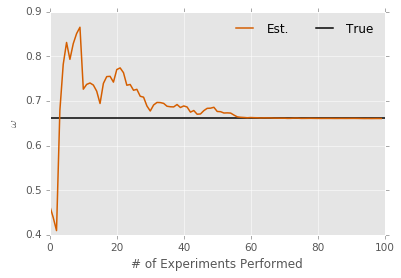

In [7]:
model = SimplePrecessionModel()
prior = UniformDistribution([0, 1])
updater = SMCUpdater(model, 2000, prior)
heuristic = ExpSparseHeuristic(updater)
true_params = prior.sample()
est_hist = []
for idx_experiment in range(100):
    experiment = heuristic()
    datum = model.simulate_experiment(true_params, experiment)
    updater.update(datum, experiment)
    est_hist.append(updater.est_mean())
plt.plot(est_hist, label='Est.')
plt.hlines(true_params, 0, 100, label='True')
plt.legend(ncol=2)
plt.xlabel('# of Experiments Performed')
plt.ylabel(r'$\omega$')
paperfig('freq-est-updater-loop')

## State and Process Tomography

In [8]:
import matplotlib

In [9]:
os.path.join(matplotlib.get_configdir(), 'stylelib')

u'/Users/ihincks/.matplotlib/stylelib'

/Users/ihincks/anaconda/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
/Users/ihincks/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


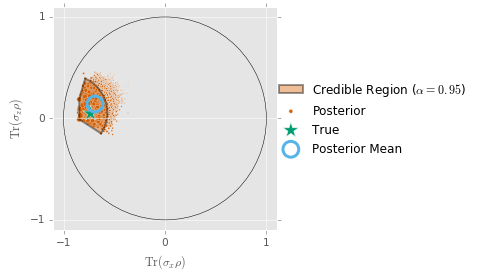

In [10]:
>>> from qinfer import *
>>> from qinfer.tomography import *
>>> basis = pauli_basis(1) # Single-qubit Pauli basis.
>>> model = TomographyModel(basis)
>>> prior = GinibreReditDistribution(basis)
>>> updater = SMCUpdater(model, 8000, prior)
>>> heuristic = RandomPauliHeuristic(updater)
>>> true_state = prior.sample()
>>>
>>> for idx_experiment in range(500):
>>>     experiment = heuristic()
>>>     datum = model.simulate_experiment(true_state, experiment)
>>>     updater.update(datum, experiment)
>>>    
>>> plt.figure(figsize=(4, 4))
>>> plot_rebit_posterior(updater, true_state=true_state, rebit_axes=[1, 3], legend=False, region_est_method='hull')
>>> plt.legend(ncol=1, numpoints=1, scatterpoints=1, bbox_to_anchor=(1.9, 0.5), loc='right')
>>> plt.xticks([-1, 0, 1])
>>> plt.yticks([-1, 0, 1])
>>> plt.xlabel(r'$\operatorname{Tr}(\sigma_x \rho)$')
>>> plt.ylabel(r'$\operatorname{Tr}(\sigma_z \rho)$')
>>> paperfig('rebit-tomo')

## Randomized Benchmarking

In [11]:
>>> from qinfer import *
>>> import numpy as np
>>> p, A, B = 0.95, 0.5, 0.5
>>> ms = np.linspace(1, 800, 201).astype(int)
>>> signal = A * p ** ms + B
>>> n_shots = 25
>>> counts = np.random.binomial(p=signal, n=n_shots)
>>> data = np.column_stack([counts, ms, n_shots * np.ones_like(counts)])
>>> mean, cov = simple_est_rb(data, n_particles=12000, p_min=0.8)
>>> print(mean, np.sqrt(np.diag(cov)))

[ 0.91391419  0.42291099  0.50319928] [ 0.03125831  0.05005263  0.00749528]


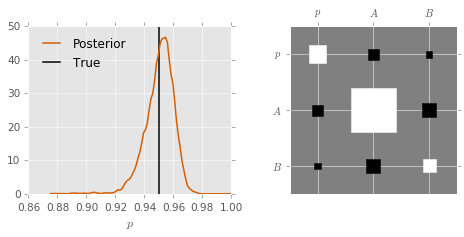

In [12]:
from qinfer import *
import numpy as np
p, A, B = 0.95, 0.5, 0.5
ms = np.linspace(1, 800, 201).astype(int)
signal = A * p ** ms + B
n_shots = 25
counts = np.random.binomial(p=signal, n=n_shots)
data = np.column_stack([counts, ms, n_shots * np.ones_like(counts)])
mean, cov, extra = simple_est_rb(data, n_particles=12000, p_min=0.8, return_all=True)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

plt.sca(axes[0])
extra['updater'].plot_posterior_marginal(range_max=1)
plt.xlim(xmax=1)
ylim = plt.ylim(ymin=0)
plt.vlines(p, *ylim)
plt.ylim(*ylim);
plt.legend(['Posterior', 'True'], loc='upper left', ncol=1)

plt.sca(axes[1])
extra['updater'].plot_covariance()

paperfig('rb-simple-est')

# Additional Functionality

---

## Derived Models

In [13]:
>>> from qinfer import *
>>> import numpy as np
>>> model = BinomialModel(SimplePrecessionModel())
>>> n_meas = 25
>>> prior = UniformDistribution([0, 1])
>>> updater = SMCUpdater(model, 2000, prior)
>>> true_params = prior.sample()
>>> for t in np.linspace(0.1,20,20):
...     experiment = np.array([(t, n_meas)], dtype=model.expparams_dtype)
...     datum = model.simulate_experiment(true_params, experiment)
...     updater.update(datum, experiment)
>>> print(updater.est_mean())

[ 0.19846487]


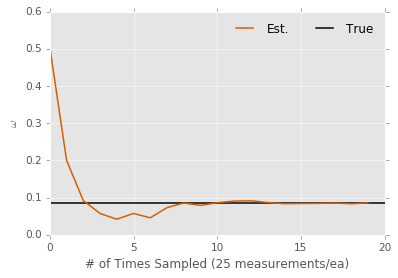

In [14]:
model = BinomialModel(SimplePrecessionModel())
n_meas = 25
prior = UniformDistribution([0, 1])
updater = SMCUpdater(model, 2000, prior)
heuristic = ExpSparseHeuristic(updater)
true_params = prior.sample()
est_hist = []
for t in np.linspace(0.1, 20, 20):
    experiment = np.array([(t, n_meas)], dtype=model.expparams_dtype)
    datum = model.simulate_experiment(true_params, experiment)
    updater.update(datum, experiment)
    est_hist.append(updater.est_mean())
plt.plot(est_hist, label='Est.')
plt.hlines(true_params, 0, 20, label='True')
plt.legend(ncol=2)
plt.xlabel('# of Times Sampled (25 measurements/ea)')
plt.ylabel(r'$\omega$')
paperfig('derived-model-updater-loop')

## Time-Dependent Models

In [15]:
>>> from qinfer import *
>>> import numpy as np
>>> prior = UniformDistribution([0, 1])
>>> true_params = np.array([[0.5]])
>>> n_particles = 2000
>>> model = RandomWalkModel(
...     BinomialModel(SimplePrecessionModel()), NormalDistribution(0, 0.01**2))
>>> updater = SMCUpdater(model, n_particles, prior)
>>> t = np.pi / 2
>>> n_meas = 40
>>> expparams = np.array([(t, n_meas)], dtype=model.expparams_dtype)
>>> for idx in range(1000):
...     datum = model.simulate_experiment(true_params, expparams)
...     true_params = np.clip(model.update_timestep(true_params, expparams)[:, :, 0], 0, 1)
...     updater.update(datum, expparams)

/Users/ihincks/anaconda/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 3 particles within 1000 iterations.
/Users/ihincks/anaconda/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 27 particles within 1000 iterations.
/Users/ihincks/anaconda/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 1 particles within 1000 iterations.
/Users/ihincks/anaconda/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 10 particles within 1000 iterations.
/Users/ihincks/anaconda/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 203 parti

In [16]:
prior = UniformDistribution([0, 1])
true_params = np.array([[0.5]])
model = RandomWalkModel(BinomialModel(SimplePrecessionModel()), NormalDistribution(0, 0.01**2))
updater = SMCUpdater(model, 2000, prior)
expparams = np.array([(np.pi / 2, 40)], dtype=model.expparams_dtype)

data_record = []
trajectory = []
estimates = []

for idx in range(1000):
    datum = model.simulate_experiment(true_params, expparams)
    true_params = np.clip(model.update_timestep(true_params, expparams)[:, :, 0], 0, 1)
    
    updater.update(datum, expparams)

    data_record.append(datum)
    trajectory.append(true_params[0, 0])
    estimates.append(updater.est_mean()[0])

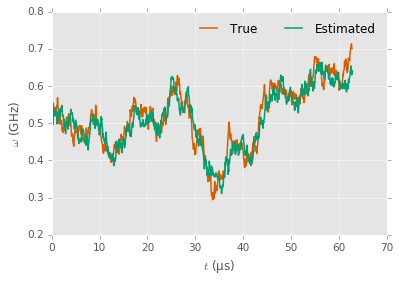

In [17]:
ts = 40 * np.pi / 2 * np.arange(len(data_record)) / 1e3
plt.plot(ts, trajectory, label='True')
plt.plot(ts, estimates, label='Estimated')
plt.xlabel(u'$t$ (µs)')
plt.ylabel(r'$\omega$ (GHz)')
plt.legend(ncol=2)
paperfig('time-dep-rabi')

## Performance and Robustness Testing

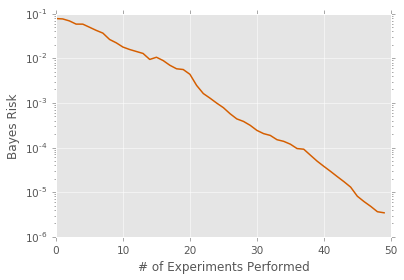

In [18]:
performance = perf_test_multiple(
    # Use 100 trials to estimate expectation over data.
    100, 
    # Use a simple precession model both to generate,
    # data, and to perform estimation.
    SimplePrecessionModel(),
    # Use 2,000 particles and a uniform prior.
    2000, UniformDistribution([0, 1]),
    # Take 50 measurements with $t_k = ab^k$.
    50, ExpSparseHeuristic
)
# Calculate the Bayes risk by taking a mean over the trial index.
risk = np.mean(performance['loss'], axis=0)
plt.semilogy(risk)
plt.xlabel('# of Experiments Performed')
plt.ylabel('Bayes Risk')
paperfig('bayes-risk')

## Parallelization

Here, we demonstrate parallelization with ipyparallel and the DirectViewParallelizedModel model.

First, create a model which is not designed to be useful, but rather to be expensive to evaluate a single likelihood.

In [19]:
class ExpensiveModel(FiniteOutcomeModel):
    """
    The likelihood of this model randomly generates 
    a dim-by-dim conjugate-symmetric matrix for every expparam and 
    modelparam, exponentiates it, and returns 
    the overlap with the |0> state.
    """
    def __init__(self, dim=36):
        super(ExpensiveModel, self).__init__()
        self.dim=dim
        
    @property
    def n_modelparams(self): 
        return 2
    @property
    def expparams_dtype(self): 
        return 'float'
    def n_outcomes(self, expparams): 
        return 2
    def are_models_valid(self, mps):
        return np.ones(mps.shape).astype(bool)
    
    def prob(self):
        # random symmetric matrix
        mat = np.random.rand(self.dim, self.dim)
        mat += mat.T
        # and exponentiate resulting square matrix
        mat = expm(1j * mat)
        # compute overlap with |0> state
        return np.abs(mat[0,0])**2
    
    def likelihood(self, outcomes, mps, eps):   
                             
        # naive for loop.
        pr0 = np.empty((mps.shape[0], eps.shape[0]))
        for idx_eps in range(eps.shape[0]):
            for idx_mps in range(mps.shape[0]):
                pr0[idx_mps, idx_eps] = self.prob()
        
        # compute the prob of each outcome by taking pr0 or 1-pr0
        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

Now, we can use Jupyter's %timeit magic to see how long it takes, for example, to compute the likelihood 5x1000x10=50000 times.

In [20]:
emodel = ExpensiveModel(dim=16)
%timeit -q -o -n1 -r1  emodel.likelihood(np.array([0,1,0,0,1]), np.zeros((1000,1)), np.zeros((10,1)))

<TimeitResult : 1 loop, best of 1: 7.52 s per loop>

Next, we initialize the Client which communicates with the parallel processing engines.
In the accompaning paper, this code was run on a single machine with dual "Intel(R) Xeon(R) CPU X5675  @ 3.07GHz" processors, for a total of 12 physical cores, and therefore, 24 engines were online.

In [21]:
# Do not demand that ipyparallel be installed, or ipengines be running;
# instead, fail silently.
run_parallel = True
try:
    from ipyparallel import Client
    import dill
    rc = Client() # set profile here if desired
    dview = rc[:]
    dview.execute('from qinfer import *')
    dview.execute('from scipy.linalg import expm')
    print("Number of engines available: {}".format(len(dview)))
except:
    run_parallel = False
    print('Parallel Engines or libraries could not be initialized; Parallel section will not be evaluated.')

Number of engines available: 24


Finally, we run the parallel tests, looping over different numbers of engines used.

In [22]:
if run_parallel:
    par_n_particles = 5000
    
    par_test_outcomes = np.array([0,1,0,0,1])
    par_test_modelparams = np.zeros((par_n_particles, 1)) # only the shape matters
    par_test_expparams = np.zeros((10, 1)) # only the shape matters
    
    def compute_L(model):
        model.likelihood(par_test_outcomes, par_test_modelparams, par_test_expparams)
        
    serial_time = %timeit -q -o -n1 -r1 compute_L(emodel)
    serial_time = serial_time.all_runs[0]
    
    n_engines = np.arange(2,len(dview)+1,2)
    par_time = np.zeros(n_engines.shape[0])
    
    for idx_ne, ne in enumerate(n_engines):
        dview_test = rc[:ne]
        dview_test.use_dill()
        par_model = DirectViewParallelizedModel(emodel, dview_test, serial_threshold=1)

        result = %timeit -q -o -n1 -r1 compute_L(par_model)
        par_time[idx_ne] = result.all_runs[0]

And plot the results.

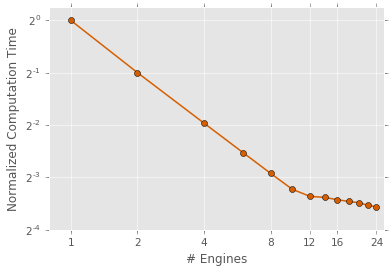

In [23]:
if run_parallel:
    fig = plt.figure()
    plt.plot(np.concatenate([[1], n_engines]), np.concatenate([[serial_time], par_time])/serial_time,'-o')
    ax = plt.gca()
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    plt.xlim([0.8, np.max(n_engines)+2])
    plt.ylim([2**-4,1.2])
    plt.xlabel('# Engines')
    plt.ylabel('Normalized Computation Time')
    par_xticks = [1,2,4,8,12,16,24]
    ax.set_xticks(par_xticks)
    ax.set_xticklabels(par_xticks)
    paperfig('parallel-likelihood')

# Appendices #
---

## Custom Models ##

In [24]:
from qinfer import FiniteOutcomeModel
import numpy as np

class MultiCosModel(FiniteOutcomeModel):

    @property
    def n_modelparams(self):
        return 2

    @property
    def is_n_outcomes_constant(self):
        return True

    def n_outcomes(self, expparams):
        return 2

    def are_models_valid(self, modelparams):
        return np.all(np.logical_and(modelparams > 0, modelparams <= 1), axis=1)

    @property
    def expparams_dtype(self):
        return [('ts', 'float', 2)]

    def likelihood(self, outcomes, modelparams, expparams):
        super(MultiCosModel, self).likelihood(outcomes, modelparams, expparams)
        pr0 = np.empty((modelparams.shape[0], expparams.shape[0]))

        w1, w2 = modelparams.T
        t1, t2 = expparams['ts'].T

        for idx_model in range(modelparams.shape[0]):
            for idx_experiment in range(expparams.shape[0]):
                pr0[idx_model, idx_experiment] = (
                    np.cos(w1[idx_model] * t1[idx_experiment] / 2) *
                    np.cos(w2[idx_model] * t2[idx_experiment] / 2)
                ) ** 2

        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [25]:
>>> mcm = MultiCosModel()
>>> modelparams = np.dstack(np.mgrid[0:1:100j,0:1:100j]).reshape(-1, 2)
>>> expparams = np.empty((81,), dtype=mcm.expparams_dtype)
>>> expparams['ts'] = np.dstack(np.mgrid[1:10,1:10] * np.pi / 2).reshape(-1, 2)
>>> D = mcm.simulate_experiment(modelparams, expparams, repeat=2)
>>> print(isinstance(D, np.ndarray))
True
>>> D.shape == (2, 10000, 81)
True

True


True